In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
pip install pandas geopandas scikit-learn numpy scipy pysal

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import geopandas as gpd
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial import cKDTree
import pysal.lib as ps

In [5]:
pip install osmnx

Note: you may need to restart the kernel to use updated packages.


In [6]:
import osmnx as ox

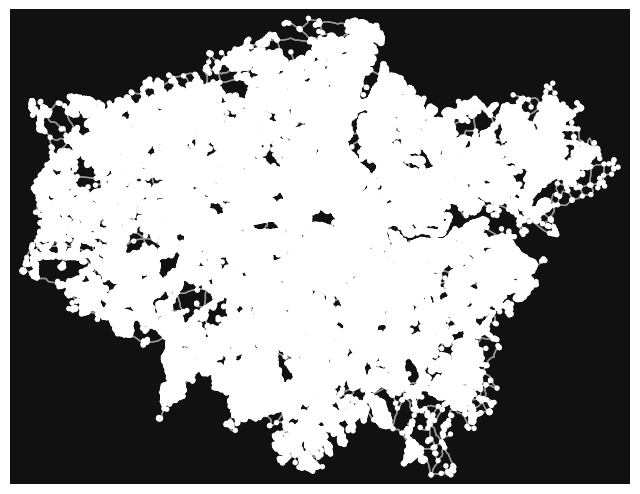

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [7]:
G = ox.graph_from_place('London, England', network_type='drive')
ox.plot_graph(G)


In [8]:
# 提取节点坐标
nodes = G.nodes(data=True)
node_points = np.array([(data['x'], data['y']) for _, data in nodes])  # 提取节点坐标（经度和纬度）

In [9]:
# Import data
Accident_London = pd.read_csv("df_per_coll_London_vru_s1.csv")
# 2019
Accident_London_2019 = Accident_London[Accident_London['accident_year_y'] == 2019]
print(f"There are {Accident_London_2019.shape[0]} rows and {Accident_London_2019.shape[1]} columns in 2019.")
print(Accident_London_2019['police_force'].value_counts().head(10))
value_counts = Accident_London_2019['casualty_type'].value_counts()
print(value_counts)

There are 10320 rows and 23 columns in 2019.
police_force
1.0     10059
48.0      261
Name: count, dtype: int64
casualty_type
0     3573
1     3193
3     2147
5      627
4      467
2      281
97      14
23      10
22       8
Name: count, dtype: int64


/tmp/ipykernel_28253/3536835873.py:2: DtypeWarning: Columns (0,2) have mixed types. Specify dtype option on import or set low_memory=False.
  Accident_London = pd.read_csv("df_per_coll_London_vru_s1.csv")


In [10]:
# 2023
Accident_London_2023 = Accident_London[Accident_London['accident_year_y'] == 2023]
print(f"There are {Accident_London_2023.shape[0]} rows and {Accident_London_2023.shape[1]} columns in 2023.")
print(Accident_London_2023['police_force'].value_counts().head(10))
value_counts = Accident_London_2023['casualty_type'].value_counts()
print(value_counts)

There are 7109 rows and 23 columns in 2023.
police_force
1.0     6950
48.0     159
Name: count, dtype: int64
casualty_type
3     2160
1     2113
0     2079
5      310
4      260
2      118
23      31
97      26
22      12
Name: count, dtype: int64


In [10]:
# 将事故数据转换为GeoDataFrame
accidents_gdf = gpd.GeoDataFrame(
    Accident_London_2019,
    geometry=gpd.points_from_xy(Accident_London_2019.longitude, Accident_London_2019.latitude),
    crs='EPSG:4326'  # 确保坐标系正确
)

In [11]:
# 找到最近的路网节点
tree = cKDTree(node_points)
accidents_coords = accidents_gdf.geometry.apply(lambda geom: (geom.x, geom.y)).tolist()
distances, indices = tree.query(accidents_coords)
accidents_gdf['nearest_osm_node'] = indices  # 将最近节点的索引存储在数据框中

In [12]:
from geopy.distance import great_circle
import itertools

def compute_shortest_distances(accidents_gdf):
    positions = [(geom.x, geom.y) for geom in accidents_gdf.geometry]
    distances = []
    
    # 计算所有事故点之间的距离（使用 geopy 计算实际地球距离）
    for (i, pos1), (j, pos2) in itertools.combinations(enumerate(positions), 2):
        distance = great_circle(pos1, pos2).meters  # 计算米为单位的距离
        distances.append((i, j, distance))  # 存储事故点的索引及其距离

    return distances

shortest_distances = compute_shortest_distances(accidents_gdf)

In [13]:
print(accidents_gdf.geometry.is_valid)

0        True
1        True
2        True
3        True
4        True
         ... 
10315    True
10316    True
10317    True
10318    True
10319    True
Length: 10320, dtype: bool


In [34]:
import libpysal as lps
from libpysal.weights import DistanceBand

# 转换CRS为合适的投影坐标系（如果需要）
if accidents_gdf.crs is None or accidents_gdf.crs.to_string() != 'EPSG:3857':
    accidents_gdf = accidents_gdf.to_crs(epsg=3857)
    
# 如果几何有效，需要提取坐标并构建权重矩阵
coordinates = np.array([geom.coords[0] for geom in accidents_gdf.geometry])  # 提取坐标



# 构建空间权重矩阵，设置阈值为100米
w = DistanceBand(coordinates, threshold=2500)

# print(w.neighbors)  # 输出每个位置的邻居列表

In [35]:
print(accidents_gdf.geometry.head())  # 输出前几行的几何数据

0    POINT (-13825.102 6715012.036)
1    POINT (-21266.921 6718518.338)
2    POINT (-11028.533 6686578.207)
3      POINT (7874.518 6720370.708)
4     POINT (-2344.945 6716164.947)
Name: geometry, dtype: geometry


In [36]:
pip show esda

Name: esda
Version: 2.6.0
Summary: Exploratory Spatial Data Analysis in PySAL
Home-page: 
Author: 
Author-email: Serge Rey <sjsrey@gmail.com>, Levi Wolf <levi.john.wolf@bristol.ac.uk>
License: BSD 3-Clause
Location: /opt/conda/lib/python3.11/site-packages
Requires: geopandas, libpysal, numpy, pandas, scikit-learn, scipy, shapely
Required-by: giddy, pysal, spaghetti, splot
Note: you may need to restart the kernel to use updated packages.


In [37]:
import esda
print(dir(esda))

['G', 'G_Local', 'Gamma', 'Geary', 'Geary_Local', 'Geary_Local_MV', 'Join_Counts', 'Join_Counts_Local', 'Join_Counts_Local_BV', 'Join_Counts_Local_MV', 'LOSH', 'Moran', 'Moran_BV', 'Moran_BV_matrix', 'Moran_Local', 'Moran_Local_BV', 'Moran_Local_Rate', 'Moran_Rate', 'PackageNotFoundError', 'Smaup', 'Spatial_Pearson', 'Spatial_Pearson_Local', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', 'adbscan', 'areal_entropy', 'boundary_silhouette', 'completeness', 'contextlib', 'crand', 'external_entropy', 'fdr', 'gamma', 'geary', 'geary_local', 'geary_local_mv', 'getisord', 'homogeneity', 'isolation', 'join_counts', 'join_counts_local', 'join_counts_local_bv', 'join_counts_local_mv', 'lee', 'losh', 'map_comparison', 'moran', 'overlay_entropy', 'path_silhouette', 'prominence', 'shape', 'silhouettes', 'smaup', 'smoothing', 'tabular', 'topo', 'util', 'version']


In [38]:
import esda.getisord as g
print(dir(g))

['G', 'G_Local', 'PERMUTATIONS', 'W', '__all__', '__author__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '__warningregistry__', '_crand_plus', '_g_local_crand', '_g_local_star_crand', '_infer_star_and_structure_w', '_njit', '_prepare_univariate', '_univariate_handler', 'fill_diagonal', 'lag_spatial', 'np', 'stats', 'warnings']


In [39]:
import libpysal as lps  # 更新后的模块导入方式
from libpysal.weights import DistanceBand

# 计算Getis-Ord Gi*统计量
accidents_density = np.ones(len(accidents_gdf))  # 每个事故点的权重
Gi_star = g.G(accidents_density, w)# 注意新的函数名称

# 输出计算的结果
print("Getis-Ord Gi* (全局):", Gi_star.G)

Getis-Ord Gi* (全局): 0.014683627176781597


/opt/conda/lib/python3.11/site-packages/esda/getisord.py:149: RuntimeWarning: divide by zero encountered in scalar divide
  self.z_sim = (self.G - self.EG_sim) / self.seG_sim


In [40]:
print(np.unique(accidents_density))  # 检查唯一密度值

[1.]


In [41]:
# 计算Z-score
gi_star_value = Gi_star.G  # 获取全局Gi*值
expected_value = Gi_star.EG  # 获取期望值 (如果在类中设计了此属性)
variance_value = Gi_star.VG  # 获取方差 (如果在类中设计了此属性)
print("Expected Value (EG):", expected_value)
print("Variance (VG):", variance_value)


Expected Value (EG): 0.014683627176781597
Variance (VG): 0.0


In [ ]:
# 如果你想计算整个的Z-score
z_score = (gi_star_value - expected_value) / np.sqrt(variance_value)

print("Z-score:", z_score)

In [ ]:
# 标记热点区与冷点
accidents_gdf['z_score'] = z_scores
accidents_gdf['hotspot'] = np.where(z_scores > 1.96, 'Hotspot', np.where(z_scores < -1.96, 'Coldspot', 'Random'))

In [ ]:
import matplotlib.pyplot as plt

# 可视化热点和冷点
fig, ax = plt.subplots(figsize=(10, 10))
osm_data.plot(ax=ax, color='grey', alpha=0.5)
accidents_gdf[accidents_gdf['hotspot'] == 'Hotspot'].plot(ax=ax, color='red', markersize=10, label='Hotspot')
accidents_gdf[accidents_gdf['hotspot'] == 'Coldspot'].plot(ax=ax, color='blue', markersize=10, label='Coldspot')
plt.title("Hotspots of Vulnerable Road Users' Accidents")
plt.legend()
plt.show()